In [44]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

import sys
sys.path.append("../")

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import particles.mcmc as mcmc
import particles.state_space_models as ssm
import particles.distributions as dists
from particles.core import SMC
from particles import smc_samplers as ssp
import seaborn
from tqdm import tqdm
import pickle
import os

from Utils import *

## Problem

The data are constituted of two independent counts of kangaroos population in New South Wales (Australia). Data are from Knape & De Valpine (2012). We aim to fit different population growth models on the historical data in order to predict the unobserved real population size from the countings.

Some global variables are defined in Utils.ssm, to help the readability of this notebook. For instance `data` (dataframe with the counts), `dt` which is the time difference between the observations, or `y` which puts the data in a correct format to use the particles package developped by N. Chopin.

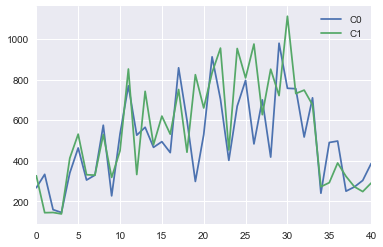

In [45]:
data[['C0','C1']].plot()

C0    4.976734
C1    4.927254
dtype: float64 C0    6.886532
C1    7.013915
dtype: float64 C0    6.115386
C1    6.173569
dtype: float64 C0    0.464843
C1    0.547350
dtype: float64


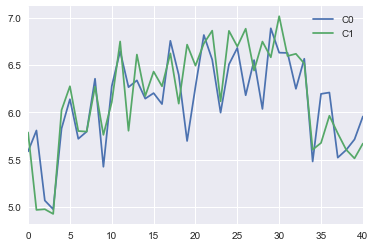

In [46]:
L_data = np.log(data[['C0', 'C1']])
L_data.plot()
print(L_data.min(), L_data.max(), L_data.mean(), L_data.std())

In [47]:
print(mean_N0, std_N0) # Parameters for the initial distribution

296.5 29.5


In [48]:
n_particles = 4000
n_iter = 20000

# Definition of a Logistic Diffusion State-Space Models

The `LogisticDiffusion` state-space model is a model with the following dynamic for the unobserved variable:

$$ \frac{dy_t}{y_t} = (r+\frac{\sigma^2}{2}-b\times y_t)dt + \sigma dW_t$$


For the emission distribution we use a negative binomial distribution with mean $y_t$ and variance $y_t + \tau y_t^2$.

In Knape & De Valpine (2012), three models are considered:
* Model 1: parameters are r, b, $\sigma$
* Model 2: b=0, parameters are r and $\sigma$
* Model 3: r=b=0, the only parameter is $\sigma$

We add a first simple model for the case where $\tau$ is also set to 0 (so the emission distribution because a Poisson of rate $y_t$).

## Tests with all models

### A Random Walk Model with Poisson emission distribution

Here is a toy example, the simplest of all with only $\sigma^2$ that is not null. Our study of each model follows the same scheme as below.

First, we launch the PMMH algorithm (or load it if it has already been done).

In [34]:
prior_RWp = {'sigma': dists.Uniform(a=0.,b=10.)}
load_model = True

if load_model:
    pmmh_RWp = pickle.load(
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/Definitive results/Chopin particles/RWp_model.pkl"
            ),
            "rb"
        )
    )
else:
    p_RWp = dists.StructDist(prior_RWp)
    pmmh_RWp = mcmc.PMMH(ssm_cls=RandomWalk2D_poisson, prior=p_RWp, data=y, Nx=n_particles,
                         niter=n_iter, adaptive=True)
    pmmh_RWp.run()
    pickle.dump(
        pmmh_RWp,
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/RWp_model.pkl"
            ),
            "wb"
        )
    )

Then, we display the following metrics to analyze the behavior of our algorithm:

    * The mean square jump distance.
    * The posterior loglikelihood from the last steps.
    * The proposals acceptance rate.
    * The last parameter values from the chain.
    
We also provide the trace plots of the particle MCMC (parameters and posterior loglikelihood).

mean square jump distance: 103.09724004980703
posterior loglikelihood: [-1040.91195536 -1040.91195536 -1041.52584849 -1041.52584849
 -1041.41760311]
Acceptance rate: 0.3889694484724236
Last terms of theta chain: [(0.75185588,) (0.75185588,) (0.65394305,)]


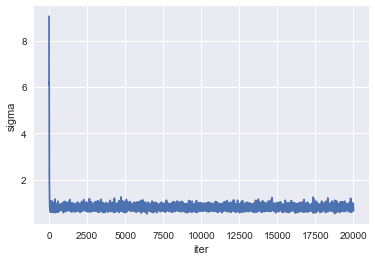

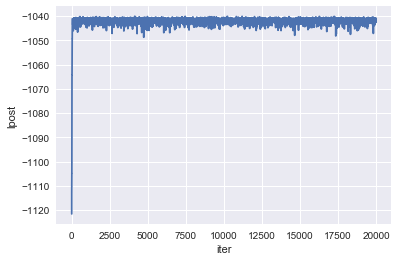

In [29]:
print_metrics(pmmh_RWp)
plot_theta(prior_RWp, pmmh_RWp)

Then, we plot the histogram of the parameter values obtained from the chain, as well as a kernel density estimator.

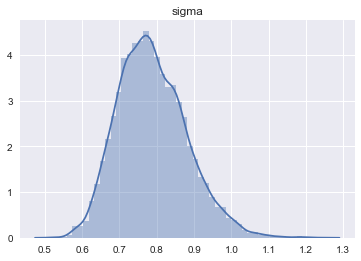

In [30]:
distplot(prior_RWp, pmmh_RWp, 1000)

The following cells provide us with a plot of our estimation of the true population size trajectory (with its confidence intervals).

In [31]:
simulRWp = get_trajectories(N=100, start=1000, model='poisson', pmmh=pmmh_RWp, n_particles=10000)

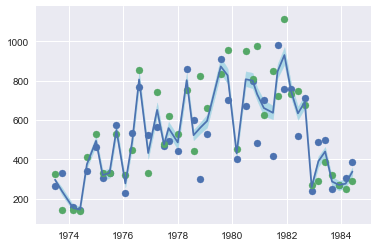

In [32]:
plot_posterior_trajectories(simulRWp)

Finally, we plot a boxplot of the loglikelihood estimates obtained from the chain (after the burnin).

-1041.7547338345973


{'boxes': [<matplotlib.lines.Line2D at 0x10c7c07b8>],
 'caps': [<matplotlib.lines.Line2D at 0x10c7bfcc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a29b05cc0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a29afea58>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10c7c0320>,
  <matplotlib.lines.Line2D at 0x10c7bf5c0>]}

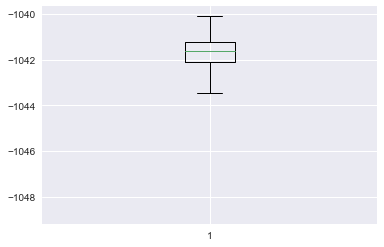

In [33]:
print(pmmh_RWp.chain.lpost[2500:].mean())
plt.boxplot(pmmh_RWp.chain.lpost[2500:])

## Random Walk Model (M3)

In [6]:
prior_RW = {'tau': dists.Uniform(a=0.,b=10.),'sigma': dists.Uniform(a=0.,b=10.)}
load_model = True



if load_model:
    pmmh_RW = pickle.load(
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/Definitive results/Chopin particles/RW_model.pkl"
            ),
            "rb"
        )
    )
else:
    p_RW = dists.StructDist(prior_RW)
    pmmh_RW= mcmc.PMMH(ssm_cls=RandomWalk2D, prior=p_RW, data=y, Nx=n_particles,
                       niter=n_iter, adaptive=True)
    pmmh_RW.run()
    pickle.dump(
        pmmh_RW,
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/RW_model.pkl"
            ),
            "wb"
        )
    )

mean square jump distance: 327.08341932115593
posterior loglikelihood: [-539.43526736 -539.64174686 -539.7528913  -539.7528913  -539.7528913 ]
Acceptance rate: 0.34130682613652275
Last terms of theta chain: [(0.39279209, 0.0766905) (0.39279209, 0.0766905) (0.39279209, 0.0766905)]


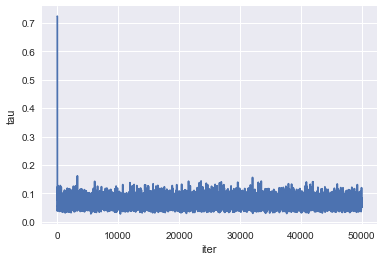

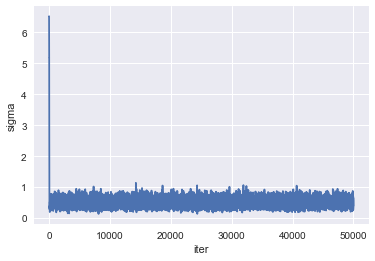

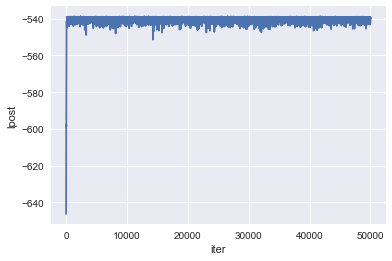

In [7]:
print_metrics(pmmh_RW)
plot_theta(prior_RW,pmmh_RW)

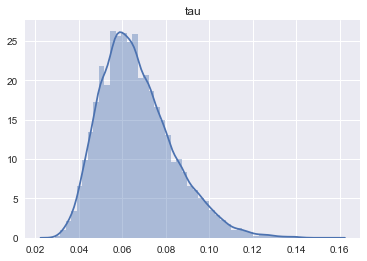

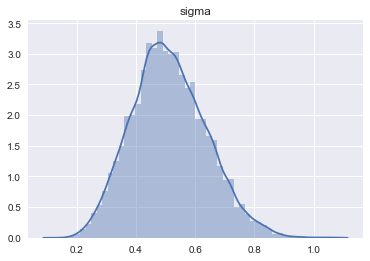

In [8]:
distplot(prior_RW, pmmh_RW, 20000)

In [9]:
simulRW = get_trajectories(N=100, start=20000, model='RW', pmmh=pmmh_RW, n_particles=10000)

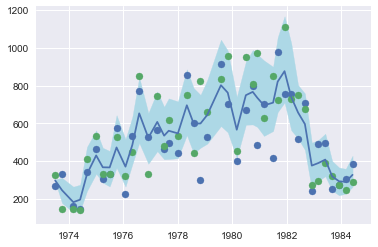

In [10]:
plot_posterior_trajectories(simulRW)

-540.120104756058


{'boxes': [<matplotlib.lines.Line2D at 0x1a27df0f28>],
 'caps': [<matplotlib.lines.Line2D at 0x1a27e19710>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a27dfffd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a27dff198>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a27e156a0>,
  <matplotlib.lines.Line2D at 0x1a27e15e80>]}

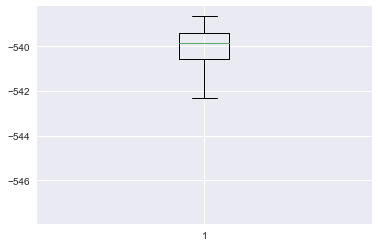

In [11]:
print(pmmh_RW.chain.lpost[20000:].mean())
plt.boxplot(pmmh_RW.chain.lpost[20000:])

## Exponential growth (M2)

In [12]:
prior_Ldrift = {'tau': dists.Uniform(a=0.,b=1.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}
load_model = True

if load_model:
    pmmh_Ldrift = pickle.load(
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/Definitive results/Chopin particles/Ldrift_model.pkl"
            ),
            "rb"
        )
    )
else:
    p_Ldrift = dists.StructDist(prior_Ldrift)
    pmmh_Ldrift= mcmc.PMMH(ssm_cls=LDPDrift, prior=p_Ldrift, data=y, Nx=n_particles,
                           niter=n_iter, adaptive=True)
    pmmh_Ldrift.run()
    pickle.dump(
        pmmh_Ldrift,
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/Ldrift_model.pkl"
            ),
            "wb"
        )
    )

mean square jump distance: 614.8392767816056
posterior loglikelihood: [-543.56520585 -543.56520585 -543.12956423 -543.12956423 -543.07669247]
Acceptance rate: 0.3029660593211864
Last terms of theta chain: [( 0.11525736, 0.60646025, 0.07214217)
 ( 0.11525736, 0.60646025, 0.07214217)
 (-0.17017468, 0.49247744, 0.07185672)]


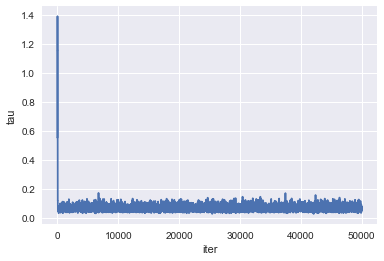

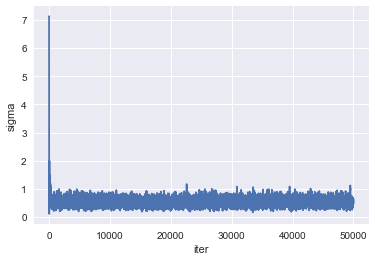

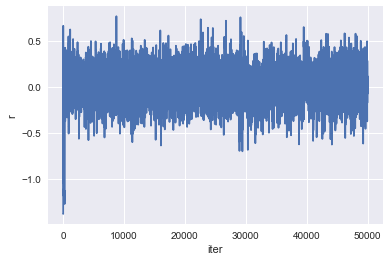

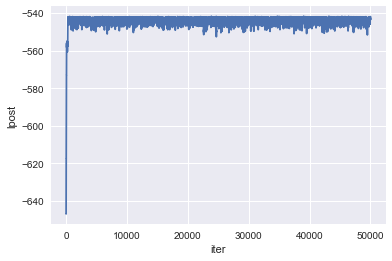

In [13]:
print_metrics(pmmh_Ldrift)
plot_theta(prior_Ldrift,pmmh_Ldrift)

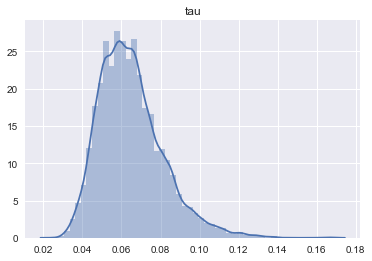

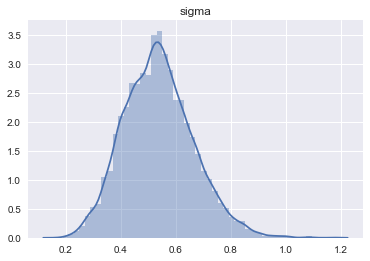

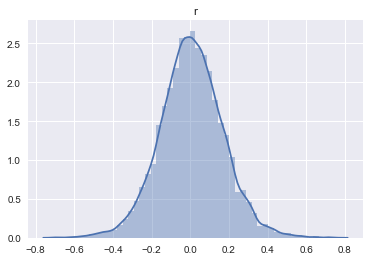

In [14]:
distplot(prior_Ldrift,pmmh_Ldrift,20000)

In [15]:
simulLDrift = get_trajectories(N=100, start=20000, model='LDrift', pmmh=pmmh_Ldrift, n_particles=10000)

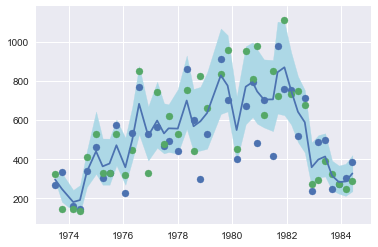

In [16]:
plot_posterior_trajectories(simulLDrift)

-543.5993795333208


{'boxes': [<matplotlib.lines.Line2D at 0x1a28dd1c88>],
 'caps': [<matplotlib.lines.Line2D at 0x1a27de88d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a27dbeac8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a28deb438>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a28dd1c50>,
  <matplotlib.lines.Line2D at 0x1a27de8898>]}

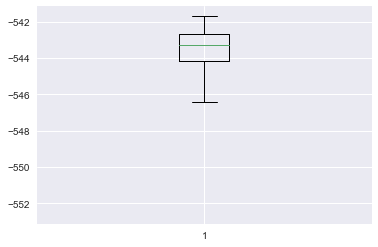

In [17]:
print(pmmh_Ldrift.chain.lpost[20000:].mean())
plt.boxplot(pmmh_Ldrift.chain.lpost[20000:])

## Logistic Diffusion process with drift and restoring force: No Euler discretization

In [41]:
prior_LD = {'tau': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=1e-2),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}
load_model = True

if load_model:
    pmmh_LD = pickle.load(
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/Definitive results/Chopin particles/LD_model.pkl"
            ),
            "rb"
        )
    )
else:
    p_LD = dists.StructDist(prior_LD)
    pmmh_LD= mcmc.PMMH(ssm_cls=LogisticDiffusion2D, prior=p_LD, data=y, Nx=n_particles,
                       niter=20000, adaptive=True)
    pmmh_LD.run()
    pickle.dump(
        pmmh_LD,
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/LD_model.pkl"
            ),
            "wb"
        )
    )

mean square jump distance: 250.5477096365952
posterior loglikelihood: [-538.57410064 -538.57410064 -538.57410064 -538.57410064 -538.73922387]
Acceptance rate: 0.24696234811740586
Last terms of theta chain: [(0.00013781,  0.21675215, 0.80438303, 0.06345662)
 (0.00013781,  0.21675215, 0.80438303, 0.06345662)
 (0.00049869, -0.12786717, 0.63196071, 0.08338723)]


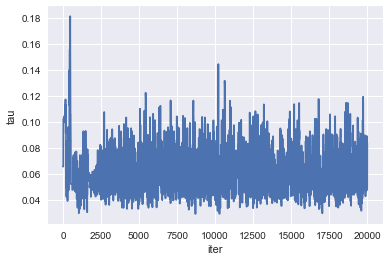

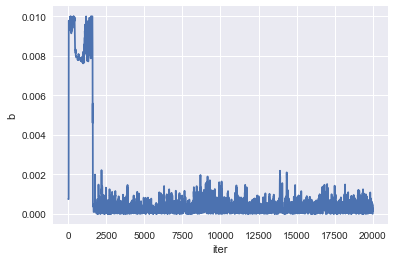

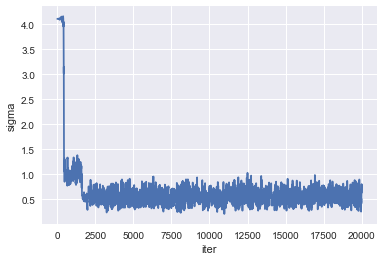

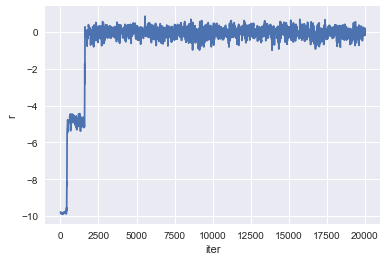

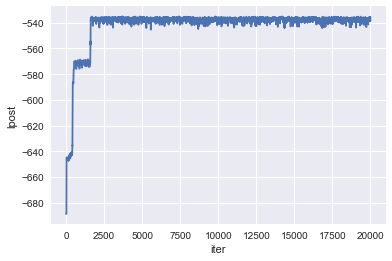

In [42]:
print_metrics(pmmh_LD)
plot_theta(prior_LD,pmmh_LD)

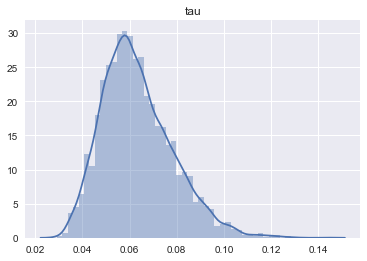

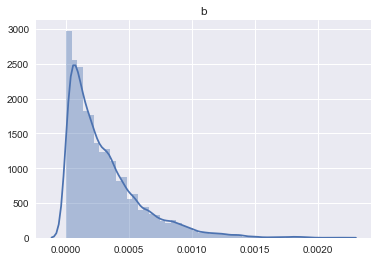

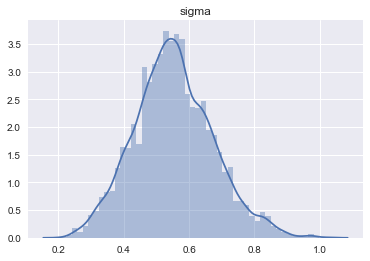

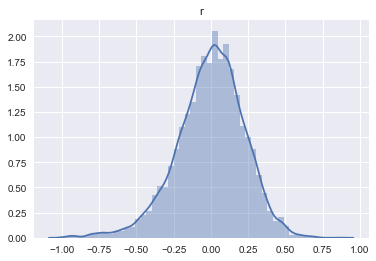

In [43]:
distplot(prior_LD,pmmh_LD, 5000)

In [21]:
simul_LD = get_trajectories(N=100, start=2500, model='LD', pmmh=pmmh_LD, n_particles=10000)

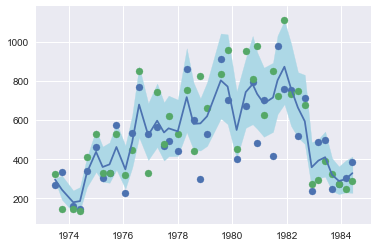

In [22]:
plot_posterior_trajectories(simul_LD)

-537.4610661187205


{'boxes': [<matplotlib.lines.Line2D at 0x1a2a18b1d0>],
 'caps': [<matplotlib.lines.Line2D at 0x1a2a1145c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a2a187cf8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a2a110320>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a2a18b390>,
  <matplotlib.lines.Line2D at 0x1a2a18b668>]}

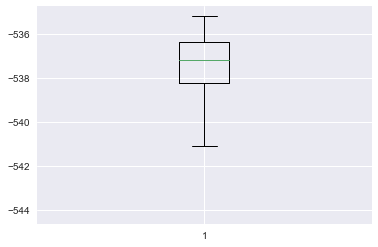

In [23]:
print(pmmh_LD.chain.lpost[10000:].mean())
plt.boxplot(pmmh_LD.chain.lpost[10000:])

## Logistic Diffusion process with Euler Discretization (M1)

### Implementation of the PMCMC

In [49]:
prior_LDEuler = {'tau': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=1e-2),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}
load_model = True

if load_model:
    pmmh_LDEuler = pickle.load(
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/Definitive results/Chopin particles/LDEuler_model.pkl"
            ),
            "rb"
        )
    )
else:
    p_LDEuler = dists.StructDist(prior_LDEuler)
    pmmh_LDEuler= mcmc.PMMH(ssm_cls=LDEuler, prior=p_LDEuler, data=y, Nx=n_particles,
                            niter=5000, adaptive=True)
    pmmh_LDEuler.run()
    pickle.dump(
        pmmh_LDEuler,
        open(
            os.path.join(
                os.getcwd(),
                "../../Data/LDEuler_model.pkl"
            ),
            "wb"
        )
    )

mean square jump distance: 41416.3119683789
posterior loglikelihood: [-555.08825855 -555.08825855 -555.08825855 -555.08825855 -555.08825855]
Acceptance rate: 0.253605072101442
Last terms of theta chain: [(0.65767996, 4.03377991, 0.18331463, 0.04343536)
 (0.65767996, 4.03377991, 0.18331463, 0.04343536)
 (0.65767996, 4.03377991, 0.18331463, 0.04343536)]


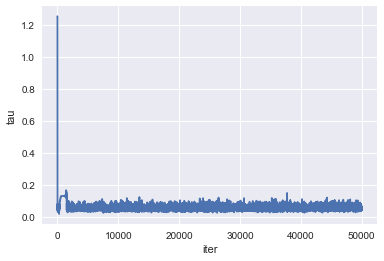

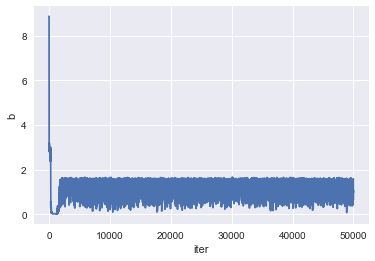

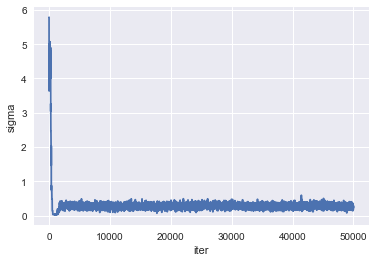

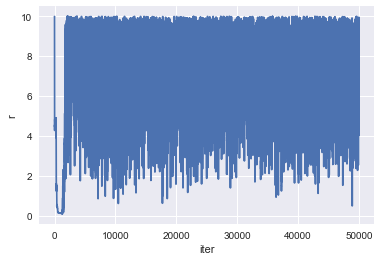

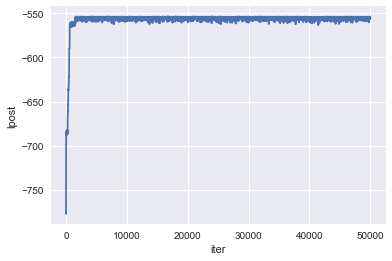

In [50]:
print_metrics(pmmh_LDEuler)
plot_theta(prior_LDEuler,pmmh_LDEuler)

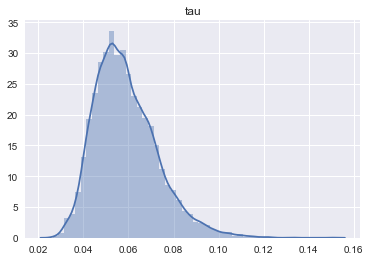

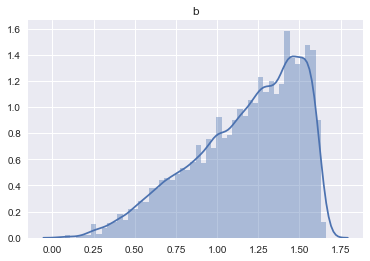

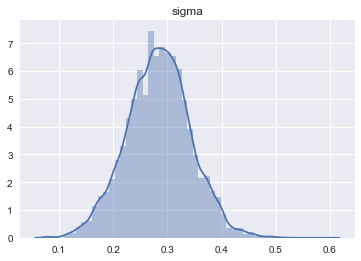

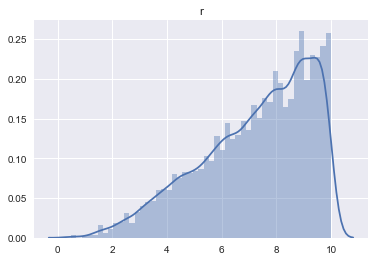

In [26]:
distplot(prior_LDEuler,pmmh_LDEuler, 20000)

The model is too unstable to sample from the posterior distribution.

-555.5457103903688


{'boxes': [<matplotlib.lines.Line2D at 0x1a2a0f9908>],
 'caps': [<matplotlib.lines.Line2D at 0x1a28867e48>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a28084128>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a280aae80>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a2a0f9cf8>,
  <matplotlib.lines.Line2D at 0x1a28867f28>]}

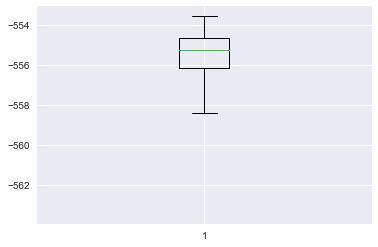

In [27]:
print(pmmh_LDEuler.chain.lpost[20000:].mean())
plt.boxplot(pmmh_LDEuler.chain.lpost[20000:])

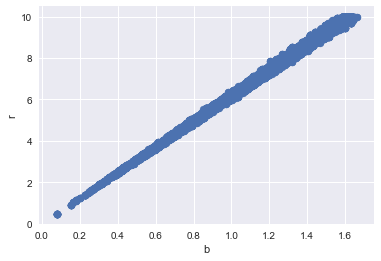

In [51]:
plt.scatter(pmmh_LDEuler.chain.theta['b'][20000:], pmmh_LDEuler.chain.theta['r'][20000:])
plt.xlabel('b')
plt.ylabel('r')